**This notebook is an exercise in the [Intro to Deep Learning](https://www.kaggle.com/learn/intro-to-deep-learning) course.  You can reference the tutorial at [this link](https://www.kaggle.com/ryanholbrook/overfitting-and-underfitting).**

---


# Introduction #

In this exercise, you’ll learn how to improve training outcomes by including an early stopping callback to prevent overfitting.

When you're ready, run this next cell to set everything up!

In [1]:
# Setup plotting
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('animation', html='html5')

# Setup feedback system
from learntools.core import binder
binder.bind(globals())
from learntools.deep_learning_intro.ex4 import *

/tmp/ipykernel_34/1500229236.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


First load the *Spotify* dataset. Your task will be to predict the popularity of a song based on various audio features, like `'tempo'`, `'danceability'`, and `'mode'`.

In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import GroupShuffleSplit

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks

spotify = pd.read_csv('../input/dl-course-data/spotify.csv')

X = spotify.copy().dropna()
y = X.pop('track_popularity')
artists = X['track_artist']

features_num = ['danceability', 'energy', 'key', 'loudness', 'mode',
                'speechiness', 'acousticness', 'instrumentalness',
                'liveness', 'valence', 'tempo', 'duration_ms']
features_cat = ['playlist_genre']

preprocessor = make_column_transformer(
    (StandardScaler(), features_num),
    (OneHotEncoder(), features_cat),
)

# We'll do a "grouped" split to keep all of an artist's songs in one
# split or the other. This is to help prevent signal leakage.
def group_split(X, y, group, train_size=0.75):
    splitter = GroupShuffleSplit(train_size=train_size)
    train, test = next(splitter.split(X, y, groups=group))
    return (X.iloc[train], X.iloc[test], y.iloc[train], y.iloc[test])

X_train, X_valid, y_train, y_valid = group_split(X, y, artists)

X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)
y_train = y_train / 100 # popularity is on a scale 0-100, so this rescales to 0-1.
y_valid = y_valid / 100

input_shape = [X_train.shape[1]]
print("Input shape: {}".format(input_shape))

2025-05-21 12:31:09.125314: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-21 12:31:09.125437: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-21 12:31:09.259775: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Input shape: [18]


Let's start with the simplest network, a linear model. This model has low capacity.

Run this next cell without any changes to train a linear model on the *Spotify* dataset.

I0000 00:00:1747830681.368111      99 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Minimum Validation Loss: 0.2000


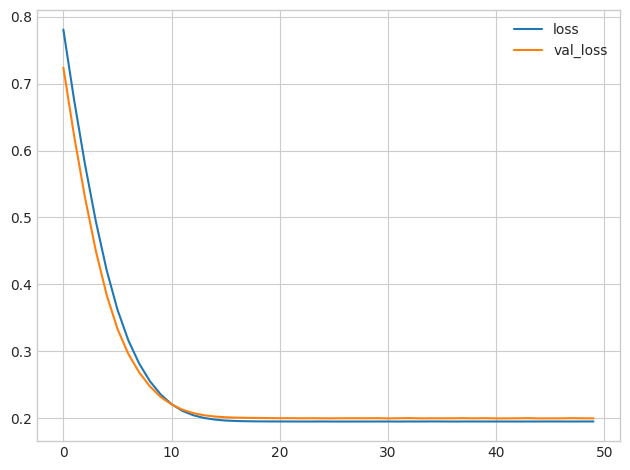

In [3]:
model = keras.Sequential([
    layers.Dense(1, input_shape=input_shape),
])
model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
    verbose=0, # suppress output since we'll plot the curves
)
history_df = pd.DataFrame(history.history)
history_df.loc[0:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

It's not uncommon for the curves to follow a "hockey stick" pattern like you see here. This makes the final part of training hard to see, so let's start at epoch 10 instead:

Minimum Validation Loss: 0.2000


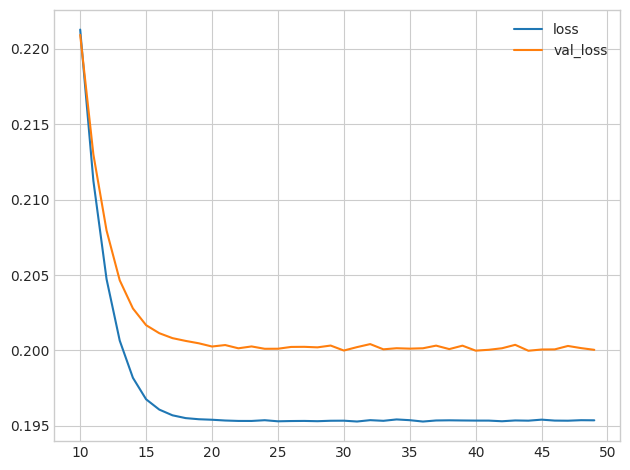

In [4]:
# Start the plot at epoch 10
history_df.loc[10:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

# 1) Evaluate Baseline

What do you think? Would you say this model is underfitting, overfitting, just right?

In [5]:
# View the solution (Run this cell to receive credit!)
q_1.check()

<IPython.core.display.Javascript object>

<span style="color:#33cc33">Correct:</span> 

The gap between these curves is quite small and the validation loss never increases, so it's more likely that the network is underfitting than overfitting. It would be worth experimenting with more capacity to see if that's the case.

Now let's add some capacity to our network. We'll add three hidden layers with 128 units each. Run the next cell to train the network and see the learning curves.

Epoch 1/50
48/48 [==============================] - 1s 6ms/step - loss: 0.2232 - val_loss: 0.2079
Epoch 2/50
48/48 [==============================] - 0s 4ms/step - loss: 0.1992 - val_loss: 0.2028
Epoch 3/50
48/48 [==============================] - 0s 4ms/step - loss: 0.1944 - val_loss: 0.2002
Epoch 4/50
48/48 [==============================] - 0s 4ms/step - loss: 0.1915 - val_loss: 0.2001
Epoch 5/50
48/48 [==============================] - 0s 4ms/step - loss: 0.1900 - val_loss: 0.2006
Epoch 6/50
48/48 [==============================] - 0s 4ms/step - loss: 0.1883 - val_loss: 0.2005
Epoch 7/50
48/48 [==============================] - 0s 4ms/step - loss: 0.1871 - val_loss: 0.1992
Epoch 8/50
48/48 [==============================] - 0s 4ms/step - loss: 0.1862 - val_loss: 0.1989
Epoch 9/50
48/48 [==============================] - 0s 4ms/step - loss: 0.1847 - val_loss: 0.1995
Epoch 10/50
48/48 [==============================] - 0s 5ms/step - loss: 0.1844 - val_loss: 0.1996
Epoch 11/50
48/48 [

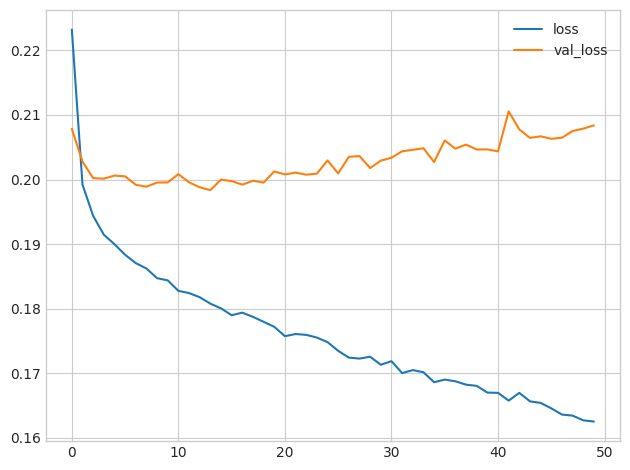

In [6]:
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])
model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

# 2) Add Capacity

What is your evaluation of these curves? Underfitting, overfitting, just right?

In [7]:
# View the solution (Run this cell to receive credit!)
q_2.check()

<IPython.core.display.Javascript object>

<span style="color:#33cc33">Correct:</span> 

Now the validation loss begins to rise very early, while the training loss continues to decrease. This indicates that the network has begun to overfit. At this point, we would need to try something to prevent it, either by reducing the number of units or through a method like early stopping. (We'll see another in the next lesson!)

# 3) Define Early Stopping Callback

Now define an early stopping callback that waits 5 epochs (`patience'`) for a change in validation loss of at least `0.001` (`min_delta`) and keeps the weights with the best loss (`restore_best_weights`).

In [11]:
from tensorflow.keras import callbacks

# YOUR CODE HERE: define an early stopping callback
early_stopping = callbacks.EarlyStopping(
    patience=5,       # Waits for 5 epochs of no improvement
    min_delta=0.001,  # Minimum change in validation loss to be considered an improvement
    restore_best_weights=True  # Keeps the weights of the best-performing epoch
)

# Check your answer
q_3.check()

<IPython.core.display.Javascript object>

<span style="color:#33cc33">Correct</span>

In [9]:
# Lines below will give you a hint or solution code
#q_3.hint()
#q_3.solution()

Now run this cell to train the model and get the learning curves. Notice the `callbacks` argument in `model.fit`.

Epoch 1/50
48/48 [==============================] - 1s 6ms/step - loss: 0.2392 - val_loss: 0.2089
Epoch 2/50
48/48 [==============================] - 0s 3ms/step - loss: 0.2003 - val_loss: 0.2023
Epoch 3/50
48/48 [==============================] - 0s 3ms/step - loss: 0.1951 - val_loss: 0.2022
Epoch 4/50
48/48 [==============================] - 0s 3ms/step - loss: 0.1920 - val_loss: 0.1993
Epoch 5/50
48/48 [==============================] - 0s 3ms/step - loss: 0.1900 - val_loss: 0.2014
Epoch 6/50
48/48 [==============================] - 0s 3ms/step - loss: 0.1884 - val_loss: 0.1996
Epoch 7/50
48/48 [==============================] - 0s 3ms/step - loss: 0.1870 - val_loss: 0.1993
Epoch 8/50
48/48 [==============================] - 0s 3ms/step - loss: 0.1860 - val_loss: 0.1985
Epoch 9/50
48/48 [==============================] - 0s 4ms/step - loss: 0.1851 - val_loss: 0.2007
Minimum Validation Loss: 0.1985


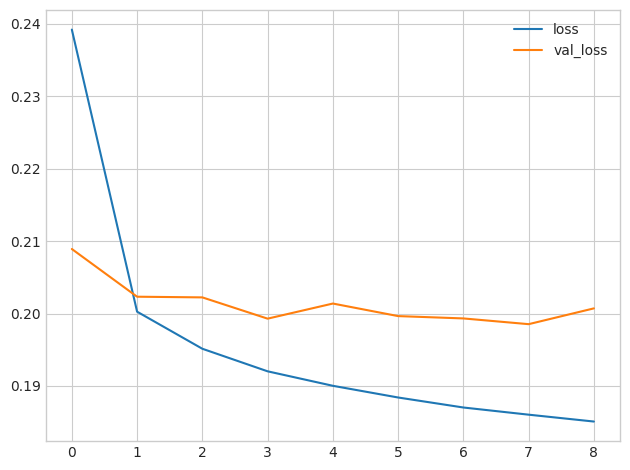

In [12]:
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dense(64, activation='relu'),    
    layers.Dense(1)
])
model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
    callbacks=[early_stopping]
)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

# 4) Train and Interpret

Was this an improvement compared to training without early stopping?

In [13]:
# View the solution (Run this cell to receive credit!)
q_4.check()

<IPython.core.display.Javascript object>

<span style="color:#33cc33">Correct:</span> 

The early stopping callback did stop the training once the network began overfitting. Moreover, by including `restore_best_weights` we still get to keep the model where validation loss was lowest.

If you like, try experimenting with `patience` and `min_delta` to see what difference it might make.

# Keep Going #

Move on to [**learn about a couple of special layers**](https://www.kaggle.com/ryanholbrook/dropout-and-batch-normalization): batch normalization and dropout.

---




*Have questions or comments? Visit the [course discussion forum](https://www.kaggle.com/learn/intro-to-deep-learning/discussion) to chat with other learners.*